In [40]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calculate_precision, calculate_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

In [41]:
# available for test:
# 20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323
# 1921, 1911, 1899, 1831, 1826, 1813, 1808, 704, 702, 635, 628, 626, 615, 593,
# 456, 454, 435, 432, 411, 401, 309, 308, 305, 302, 239, 228, 231, 200, 158, 150, 
# 126, 119, 118, 117, 116, 115, 114, 113

# available for experiments:
# 114, 115, 116, 117, 119, 302, 303, 304, 305, 306, 307,
# 308, 309, 393, 442, 470, 471, 472, 502, 503, 504, 505,
# 506, 507, 508, 511, 512, 513, 514, 515, 516, 591, 592,
# 593, 596, 597, 599, 612, 613, 614, 615, 616, 617, 618,
# 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629,
# 836, 837, 838, 839, 862, 863, 874, 875, 888, 1820, 1832,
# 1833, 1834, 1835, 1836, 1838, 1896, 1899, 4007

# small outliers:
# 114, 119, 302, 303, 442, 511, 512, 514, 629, 838, 839

# big bugs
# 307, 393, 503, 504, 505, 516, 619, 1838, 1896 -- big bugs

## Loading data

In [13]:
%%time
train_station_id = [456, 454, 435, 432, 411, 401, 309, 308, 305, 302, 239, 228, 200, 152, 150, 
                    126, 119, 118, 117, 116, 115, 114, 113, 1820,
                    20921, 20916, 20761, 20755, 20754, 20743, 20717, 20323,
                    628, 626, 615, 593, 456, 454, 435, 432, 411, 401,
                    302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896] 
#                    613, 614, 616, 617, 618, 619, 620, 621, 622, 623, 
#                    624, 625, 627, 629, 836, 837, 838, 839, 862, 863, 
#                    874, 875, 888, 1820, 1832, 1833, 1834, 1835, 1836, 
#                    1838, 1896, 4007]

raw = load_mm94_stations(train_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

data = data.reset_index(drop=True)

data_clean = get_clean_data(data)
del raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


No clean data for station 303. It will not be added into resulting dataframe
No clean data for station 307. It will not be added into resulting dataframe
No clean data for station 393. It will not be added into resulting dataframe
No clean data for station 442. It will not be added into resulting dataframe
No clean data for station 503. It will not be added into resulting dataframe
No clean data for station 504. It will not be added into resulting dataframe
No clean data for station 511. It will not be added into resulting dataframe
No clean data for station 516. It will not be added into resulting dataframe
No clean data for station 1820. It will not be added into resulting dataframe
No clean data for station 1838. It will not be added into resulting dataframe
No clean data for station 1896. It will not be added into resulting dataframe
CPU times: user 1min 40s, sys: 9.22 s, total: 1min 49s
Wall time: 1min 50s


## Plot

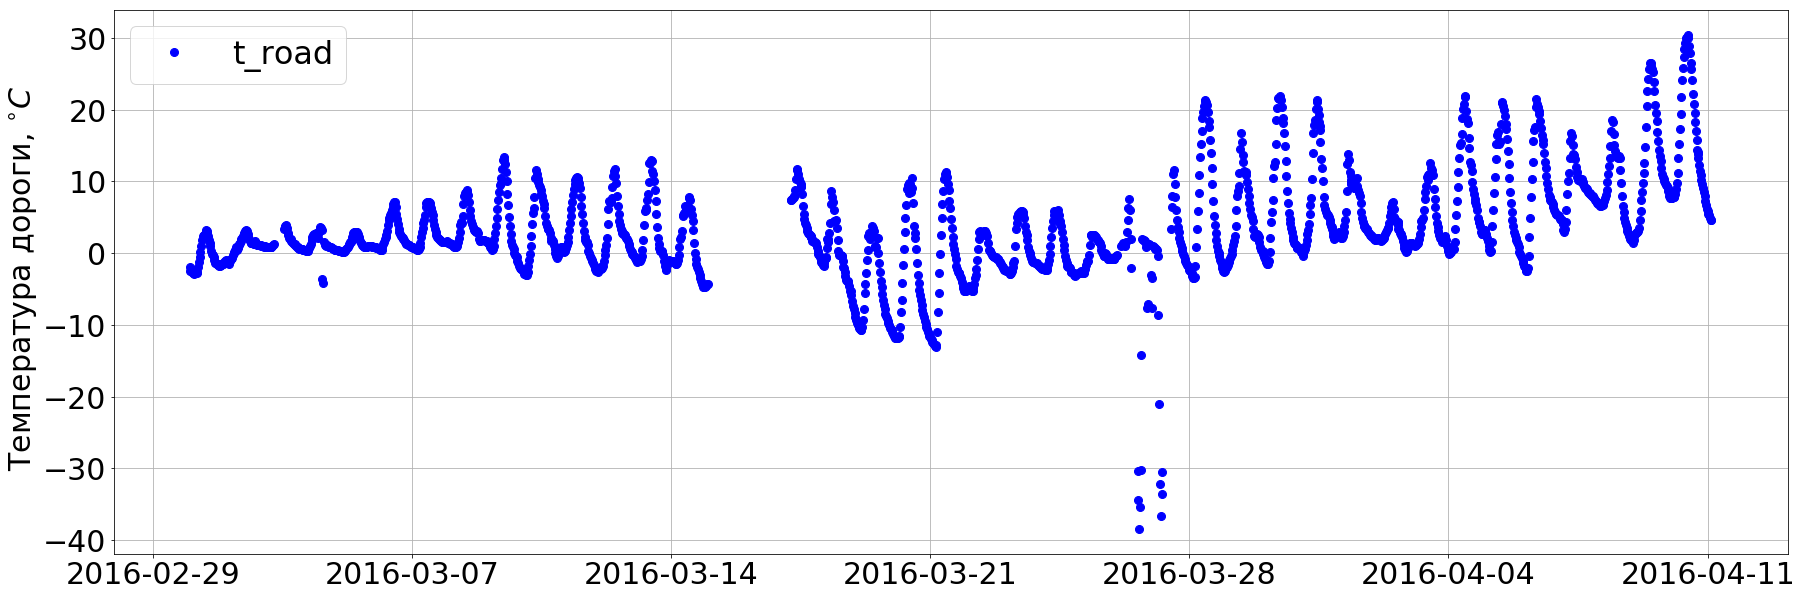

In [39]:
import matplotlib.pyplot as plt

#train_station_id = [113, 114, 115, 116, 117, 118, 119, 126, 150, 152, 200, 228, 
#                    239, 302, 302, 303, 305, 307, 308, 309, 393, 401, 401, 411, 
#                    432, 432, 435, 435, 442, 454, 454, 456, 456, 503, 504, 511, 
#                    516, 593, 615, 626, 628, 1820, 1838, 1896, 20323, 20717, 
#                    20743, 20754, 20755, 20761, 20916, 20921]

z = copy(data[data['station_id']==302].set_index('date_time_utc'))

start = pd.Timestamp(2016, 3, 1)
end = pd.Timestamp(2016, 5, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['data_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()

## Generated anomalies

In [46]:
test = copy(data[data['station_id']==302])

start = pd.Timestamp(2016, 3, 1)
end = pd.Timestamp(2016, 5, 1)
test = test[(test['date_time_utc']<=end) & (test['date_time_utc']>=start)]
test = test.reset_index(drop=True)

tet

,date_time_utc,station_id,data_t_underroad,data_pressure,date_time,data_t_air,id_t_road,data_t_road,data_dampness,data_solar_azimuth,data_solar_altitude,data_latitude,data_longitude,data_road
0,2016-03-01 00:00:00,302,-2.100000,756.500000,2016-03-01 03:00:00,-1.350000,1.032651e+09,-2.000000,100.000000,3.035012,-0.681104,54.447,53.603,54
1,2016-03-01 00:30:00,302,-2.500000,756.500000,2016-03-01 03:30:00,-1.850000,1.032651e+09,-2.500000,100.000000,-3.079833,-0.682811,54.447,53.603,54
2,2016-03-01 01:00:00,302,-2.650000,756.500000,2016-03-01 04:00:00,-1.850000,1.032676e+09,-2.500000,100.000000,-2.913881,-0.664875,54.447,53.603,54
3,2016-03-01 01:30:00,302,-2.700000,757.000000,2016-03-01 04:30:00,-2.100000,1.032701e+09,-2.650000,100.000000,-2.751821,-0.641739,54.447,53.603,54
4,2016-03-01 02:00:00,302,-2.800000,757.000000,2016-03-01 05:00:00,-2.250000,1.032725e+09,-2.750000,100.000000,-2.596289,-0.607429,54.447,53.603,54
5,2016-03-01 02:30:00,302,-2.850000,757.000000,2016-03-01 05:30:00,-2.400000,1.032751e+09,-2.850000,100.000000,-2.448652,-0.563257,54.447,53.603,54
6,2016-03-01 03:00:00,302,-2.850000,757.000000,2016-03-01 06:00:00,-2.500000,1.032775e+09,-2.900000,100.000000,-2.309340,-0.510683,54.447,53.603,54
7,2016-03-01 03:30:00,302,-2.900000,757.000000,2016-03-01 06:30:00,-2.550000,1.032800e+09,-2.750000,100.000000,-2.178038,-0.451173,54.447,53.603,54
8,2016-03-01 04:00:00,302,-2.950000,757.000000,2016-03-01 07:00:00,-2.800000,1.032825e+09,-2.700000,100.000000,-2.053927,-0.386115,54.447,53.603,54
9,2016-03-01 04:30:00,302,-3.000000,757.000000,2016-03-01 07:30:00,-2.900000,1.032850e+09,-2.850000,100.000000,-1.935894,-0.316772,54.447,53.603,54
